### Segmentace obrazu

In [206]:
import numpy as np
from scipy import ndimage
import cv2
from matplotlib import pyplot as plt
import gridcut ## Py wrapper for GridCut: https://github.com/Borda/GridCut-python

In [220]:
def load_image(path):
    im = cv2.imread("./imgs/"+path)
    return im

def save_image(img, path):
    cv2.imwrite("./results/"+path, img)

In [221]:
img = load_image("rose2.jpg")
stencil = load_image("rose2_scr5.png")
both = load_image("rose2_b.jpg")

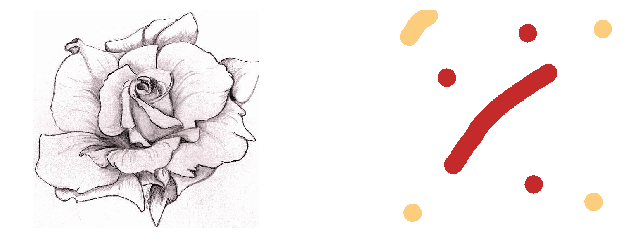

In [222]:
f, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].axis("off")
ax[1].imshow(cv2.cvtColor(stencil, cv2.COLOR_BGR2RGB))
ax[1].axis("off")
plt.show()

In [223]:
def pick_color(color):
    colors = [False,False]
    
    bgr_white = [255,255,255]
    
    for (x,y), pix in np.ndenumerate(color[:,:,0]):
        pix = color[x,y,:]
        p_list = list(pix)
        if(p_list != bgr_white and colors[0]==False):
            color_A = pix
            colors[0] = True
        elif(p_list != bgr_white and p_list != list(color_A) and colors[0] == True and colors[1] == False):
            color_B = pix
            return [color_A,color_B]
    
            
colors = pick_color(stencil)
print(colors)

[array([124, 205, 251], dtype=uint8), array([ 42,  42, 197], dtype=uint8)]


In [224]:
def set_sink(stencil, K, colors,l=1.0):
    sink = np.zeros((stencil.shape[0], stencil.shape[1]))
    
    for (x,y), pix in np.ndenumerate(stencil[:,:,0]):
        pix = stencil[x,y,:]
        if(list(pix) == list(colors[0])):
            sink[x,y] = K*l
        else:
            sink[x,y] = 0
            
    return sink

In [225]:
def set_source(stencil, K, colors,l=1.0):
    source = np.zeros((stencil.shape[0], stencil.shape[1]))
    
    for (x,y), pix in np.ndenumerate(stencil[:,:,0]):
        pix = stencil[x,y,:]
        if(list(pix) == list(colors[1])):
            source[x,y] = K*l
        else:
            source[x,y] = 0
            
    return source

In [226]:
def compute_min(a, b, K, gamma):
    lower = min(a,b)/255.0
    return 1 + K * (lower**gamma)

In [227]:
def set_edges(img, K, gamma):
    values = []
    print("before edge setting")
    edges_u = np.ones((img.shape[0], img.shape[1]), dtype=np.float32)
    edges_d = np.ones((img.shape[0], img.shape[1]), dtype=np.float32)
    edges_l = np.ones((img.shape[0], img.shape[1]), dtype=np.float32)
    edges_r = np.ones((img.shape[0], img.shape[1]), dtype=np.float32)
    
    for (x,y), pix in np.ndenumerate(img[:,:,0]):
        if(x < img.shape[0]-1):
            cap = compute_min(img[x,y,0], img[x+1,y,0],K,gamma)
            edges_u[x,y] = cap
            values.append(cap)
        if(x > 0):
            cap = compute_min(img[x,y,0], img[x-1,y,0],K,gamma)
            edges_d[x,y] = cap
            values.append(cap)
        if(y < img.shape[1]-1):
            cap = compute_min(img[x,y,0], img[x,y+1,0],K,gamma)
            edges_r[x,y] = cap
            values.append(cap)
        if(y > 0):
            cap = compute_min(img[x,y,0], img[x,y-1,0],K,gamma)
            edges_l[x,y] = cap
            values.append(cap)
            
            
    print(min(values),max(values))
    return edges_u, edges_d, edges_l, edges_r

### Vlastní segmentace a barvení:

In [228]:
def segmenter(image_org, color, colors, sink, source, K, g):
    e_u, e_d, e_l, e_r = set_edges(image_org, K, g)
    print("after edge setting")
    image = image_org.copy()
    
    w = image.shape[1]
    h = image.shape[0]
    
    a = source.ravel().astype(dtype=np.float32)
    b = sink.ravel().astype(dtype=np.float32)

    
    result = gridcut.maxflow_2D_4C(w,h, a,b, e_u.ravel(),e_d.ravel(),e_l.ravel(),e_r.ravel())
    print(set(result))
    
    idx = 0
    for (x,y), pix in np.ndenumerate(image[:,:,0]):
        if(sum(list(image[x,y,:])) > 0):
            if(result[idx]==0):
                image[x,y,:] = (image[x,y,0]/255.0) *colors[1]
            elif(result[idx]==1):
                image[x,y,:] = (image[x,y,0]/255.0) *colors[0]
        idx += 1
        
    f, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].axis("off")
    ax[1].imshow(cv2.cvtColor(stencil, cv2.COLOR_BGR2RGB))
    ax[1].axis("off")
    plt.title("K: "+str(K)+" gamma:"+str(g))
    plt.savefig(".\results\rose_"+"K"+str(K)+"_gamma"+str(g)+".png")
    plt.show()
    
    save_image(image,"rose5_"+str(K)+"_"+str(g)+".jpg")

In [236]:
print("obvod obazku:", 2*img.shape[0]+2*img.shape[1])
K = 2000
sink = set_sink(stencil, K, colors, 0.05)
source = set_source(stencil, K, colors, 0.05)

obvod obazku: 2288


before edge setting
1.0 2001.0
after edge setting
{0, 1}


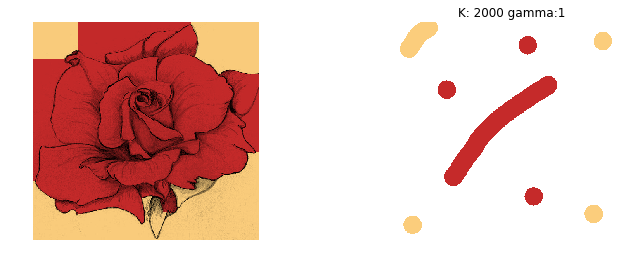

In [231]:
segmenter(img,stencil, colors, sink, source, K, g=1)

In [ ]:
for g in [0.5,1,3,5,8,10]:
    segmenter(img,stencil, colors, sink, source, K, g)

2288